### 继MATLAB之后，对生成的数据进行处理

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lb
print(lb.__version__)

0.10.2.post1


#### 读取数据

In [85]:
'''读取数据'''
import os
path = './audios'
category = 'costas_cw'

#直达区回波信号
direct_path = os.path.join(path, category ,'_direct.wav') 
#第一声影区和会聚区回波
shad_1st_path, convg_1st_path = os.path.join(path,category+'_1st_shadow.wav'), os.path.join(path,category+'_1st_convergence.wav')
#第二声影区和会聚区回波
shad_2nd_path, convg_2nd_path  = os.path.join(path,category+'_2nd_shadow.wav'), os.path.join(path,category+'_2nd_convergence.wav')
#第三声影区和会聚区
shad_3rd_path, convg_3rd_path = os.path.join(path,category+'_3rd_shadow.wav'), os.path.join(path,category+'_3rd_convergence.wav')


shad_1st_echo ,sr= lb.load(shad_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_echo ,sr= lb.load(convg_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_echo,shad_1st_echo = np.array(convg_1st_echo), np.array(shad_1st_echo)

shad_2nd_echo ,sr= lb.load(shad_2nd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_2nd_echo ,sr= lb.load(convg_2nd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_2nd_echo,shad_2nd_echo = np.array(convg_2nd_echo), np.array(shad_2nd_echo)

shad_3rd_echo ,sr= lb.load(shad_3rd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_3rd_echo ,sr= lb.load(convg_3rd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_3rd_echo,shad_3rd_echo = np.array(convg_3rd_echo), np.array(shad_3rd_echo)


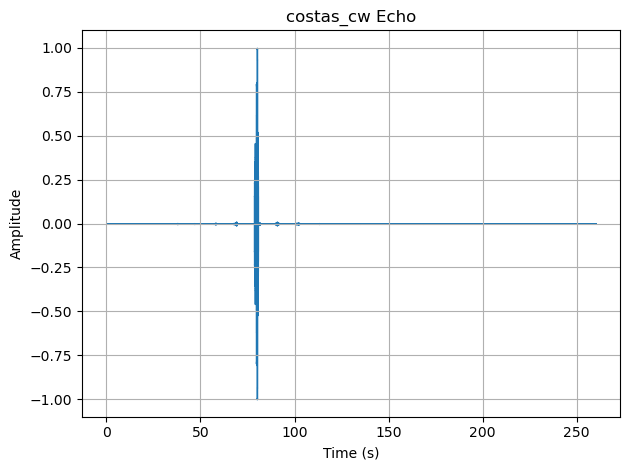

In [86]:
#读取采样率sr
sr = lb.get_samplerate(os.path.join(path, 'costas_cw_1st_shadow.wav'))
#绘制信号波形
lb.display.waveshow(convg_1st_echo, sr=sr,axis='s')
plt.title(category+' Echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

### 采用频域自适应滤波进行抗干扰,无作用

不是很成功,成功分离需要的信号,但是需要被去除的信号被放大,采用第二个函数的方法,干扰信号相比第一个幅值小一些,但是仍很不理想

FDAF（频域自适应滤波器）： FDAF算法通过将输入信号和滤波器系数转换到频域，以频域乘法替代时域卷积，从而降低计算复杂度。然而，对于长脉冲响应（即滤波器长度较长）的情况，FDAF需要处理大块的数据，这可能导致较高的延迟和内存需求。

PFDAF（分区频域自适应滤波器）： 为了解决FDAF在长脉冲响应情况下的高延迟问题，PFDAF算法将滤波器的脉冲响应分成较短的部分（分区），对每个部分分别应用FDAF，然后合并中间结果。这种方法有效地减少了延迟，同时保持了计算复杂度的降低和收敛速度的提高。

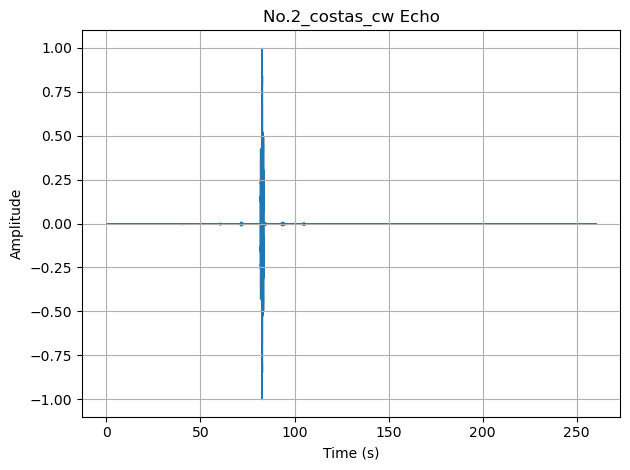

In [87]:
'''读取另一个波形的第一声影区和会聚区回波'''
category='No.2_costas_cw'
shad_1st_path, convg_1st_path = os.path.join(path,category+'_1st_shadow.wav'), os.path.join(path,category+'_1st_convergence.wav')

shad_1st_interference ,sr= lb.load(shad_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_interference ,sr= lb.load(convg_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_interference,shad_1st_interference = np.array(convg_1st_interference), np.array(shad_1st_interference)

#绘制信号波形
lb.display.waveshow(convg_1st_interference, sr=sr,axis='s')
plt.title(category+' Echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

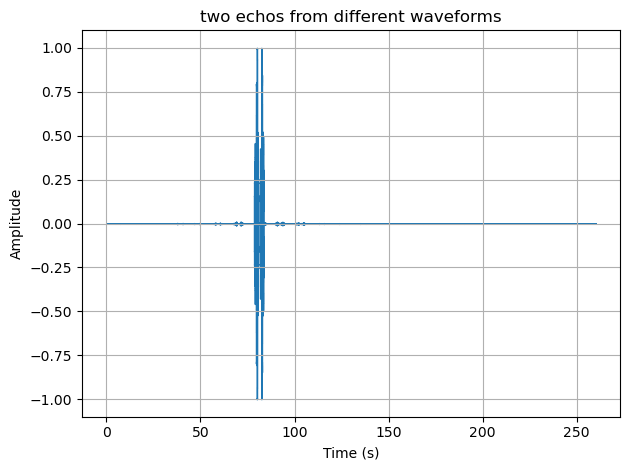

d:\01_Projects\03_Orthogonal Waveform Design and Detection\fdaf.py:55: RuntimeWarning: overflow encountered in divide
  G = X_n.conj() * E_n / norm
d:\01_Projects\03_Orthogonal Waveform Design and Detection\fdaf.py:56: RuntimeWarning: invalid value encountered in multiply
  H += mu * G


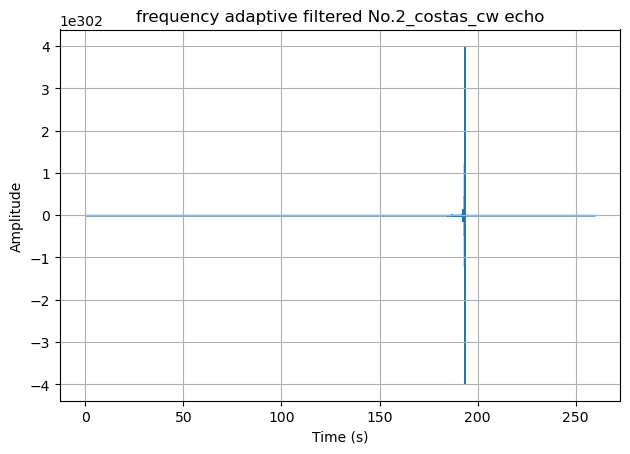

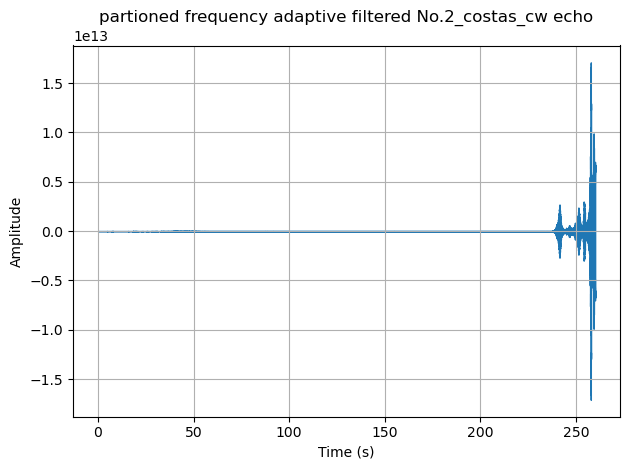

In [88]:
""" frequency domain adaptive filter """
from fdaf import fdaf 
from pfdaf import pfdaf

#设定帧长和帧移
frame_length ,hop_length =2048, 512

# x为干扰信号
# 在较短的数组后面填充 0

x = convg_1st_interference
d = convg_1st_echo + convg_1st_interference

lb.display.waveshow(d, sr=sr,axis='s')
plt.title('two echos from different waveforms')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

'''频域滤波'''
e = fdaf(x, d, M=frame_length,hop=hop_length, mu=0.2, beta=0.9)
'''partial filtered'''
e2 = pfdaf(x, d, N=4, filter_length=frame_length, hop=hop_length, mu=0.2, partial_constrain=True)



#替换 NaN 和 Inf 值，并显示数据数组
if not np.isfinite(e).all():
    e = np.nan_to_num(e)  # 将 NaN 和 Inf 值替换为 0
lb.display.waveshow(e.T, sr=sr,axis='s')
plt.title('frequency adaptive filtered '+category+' echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()


lb.display.waveshow(e2, sr=sr,axis='s')
plt.title('partioned frequency adaptive filtered '+category+' echo')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

### 添加噪声

In [68]:
def awgn(x, snr, out='signal', method='vectorized', axis=0):
    '''
    添加噪声,由matlab更改而来
    https://www.cnblogs.com/minyuan/p/14078114.html
    '''
    # Signal power
    if method == 'vectorized':
        N = x.size
        Ps = np.sum(x ** 2 / N)

    elif method == 'max_en':
        N = x.shape[axis]
        Ps = np.max(np.sum(x ** 2 / N, axis=axis))

    elif method == 'axial':
        N = x.shape[axis]
        Ps = np.sum(x ** 2 / N, axis=axis)
    else:
        raise ValueError('method \"' + str(method) + '\" not recognized.')
    # Signal power, in dB
    Psdb = 10 * np.log10(Ps)
    # Noise level necessary
    Pn = Psdb - snr
    # Noise vector (or matrix)
    n = np.sqrt(10 ** (Pn / 10)) * np.random.normal(0, 1, x.shape)
    if out == 'signal':
        return x + n
    elif out == 'noise':
        return n
    elif out == 'both':
        return x + n, n
    else:
        return x + n

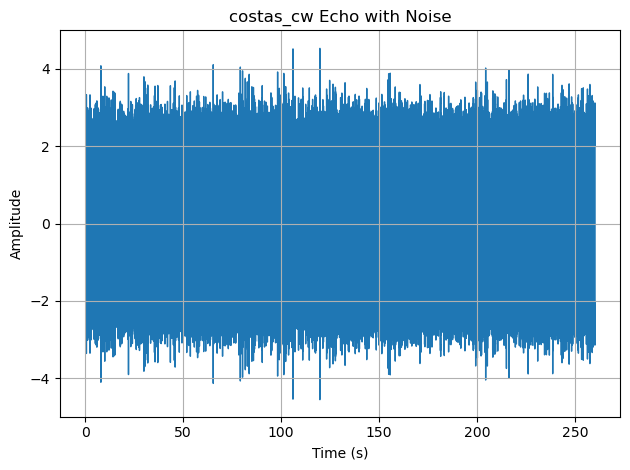

In [83]:
#添加白噪声
convg_1st_echo = awgn(convg_1st_echo,-15)  #-15dB
#绘制信号波形
lb.display.waveshow(convg_1st_echo, sr=sr,axis='s')
plt.title(category+' Echo with Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

### 使用PCA去噪

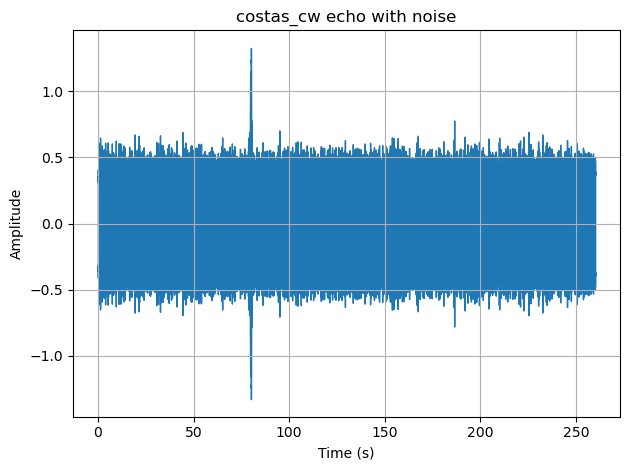

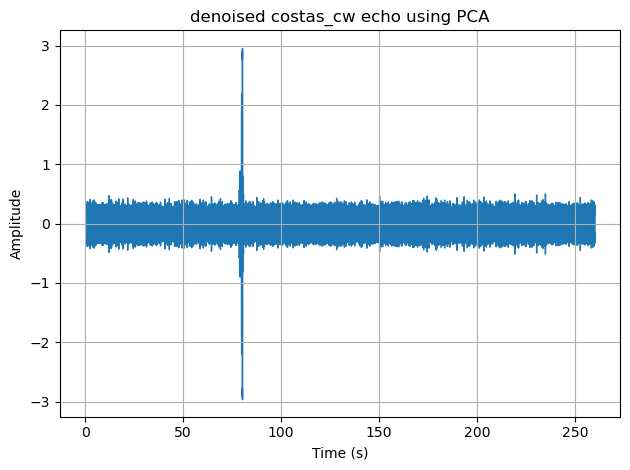

In [70]:
import padasip as pa

# 构造轨迹矩阵：将一维信号转换为嵌入矩阵，参数 L 为嵌入维数
def trajectory_matrix(signal, L):
    # signal: 1D 数组
    # L: 嵌入维数（窗口长度）
    N = len(signal)
    K = N - L + 1
    return np.array([signal[i:i+K] for i in range(L)]).T

# 对轨迹矩阵进行对角线平均，重构出一维信号（SSA 中常用的重构方法）
def diagonal_averaging(X):
    L, K = X.shape
    N = L + K - 1
    recon = np.zeros(N)
    counts = np.zeros(N)
    for i in range(L):
        for j in range(K):
            recon[i+j] += X[i, j]
            counts[i+j] += 1
    return recon / counts

# 假设此处已经添加了白噪声
# convg_1st_echo = awgn(convg_1st_echo, -5)

# 参数设置
embedding_dim = 50   # 嵌入维数，可以根据实际情况调整
# 构造轨迹矩阵
X = trajectory_matrix(convg_1st_echo, embedding_dim)

# 查看主成分的特征值（降序排列），帮助确定保留几个主成分
#eigenvalues = pa.preprocess.PCA_components(X)
#print("Eigenvalues:", eigenvalues)

# 假设保留前 n_keep 个主成分（通常较大的几个成分包含信号主要信息，而噪声较多分布在后续成分中）
n_keep = 3
# 进行 PCA 降维，new_X 的每一行对应原始样本在主成分空间中的投影
new_X = pa.preprocess.PCA(X, n_keep)

# 这里 new_X 为降维后的数据（每行包含 n_keep 个值），
# 为重构信号，我们可以对 new_X 的转置进行对角线平均
denoised_signal = diagonal_averaging(new_X.T)

# 绘制原始带噪信号波形
plt.figure()
lb.display.waveshow(convg_1st_echo, sr=sr, axis='s')
plt.title(category + ' echo with noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

# 绘制降噪后的信号波形
plt.figure()
lb.display.waveshow(denoised_signal, sr=sr, axis='s')
plt.title('denoised ' + category + ' echo using PCA')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()

### 分帧并计算每帧能量or过零率

In [71]:
#设定帧长和帧移
frame_length ,hop_length =2048, 512

# 对音频数据进行填充（必要步骤，可确保分帧完整）
padded_y = np.pad(convg_1st_echo, (frame_length // 2, frame_length // 2), mode='reflect')

#进行分帧
frames = lb.util.frame(padded_y, frame_length=frame_length, hop_length=hop_length)

# 计算每帧的能量
frame_energies = np.sum(np.abs(frames) ** 2, axis=0)

#读取过零率
zcrs = lb.feature.zero_crossing_rate(padded_y, frame_length = frame_length, hop_length = hop_length, center = True) 

In [72]:
'''frames的每一列为一帧'''
print(len(frames[0]))
print(len(frames[:,0]))
print(f"帧数：{len(frames[0])}")
print(f"第一帧过零率：{zcrs[0,1]}")


2032
2048
帧数：2032
第一帧过零率：0.3623046875


In [73]:
max_zcr = max(zcrs[0])
max_energy = max(frame_energies)
vad_idx = []
'''结合能量检测'''
# for i,energy in enumerate(frame_energies):
#     if energy >= 0.1*max_energy:
#         vad_idx.append(i)
'''过零率检测'''
# for i,zcr in enumerate(zcrs[0]):
#     if zcr <= 0.7*max_zcr:
#         vad_idx.append(i)
'''同时结合能量和 ZCR'''
vad_idx = [i for i, (zcr, energy) in enumerate(zip(zcrs[0], frame_energies))
           if zcr >= 0.4 * max_zcr and energy >= 0.1 * max_energy]

pulse_start = (vad_idx[0]*hop_length+frame_length)/sr
pulse_end = (vad_idx[-1]*hop_length+frame_length)/sr
pulse_len = pulse_end - pulse_start

print(f'脉冲的帧索引{vad_idx}')
print(f"脉冲长度{pulse_len}s")

# 保证结束索引不超过 frames 的最大列数
end_idx = min(vad_idx[-1] + 1, frames.shape[1])
extracted_frames = frames[:, vad_idx[0]:vad_idx[-1] + 1]

脉冲的帧索引[400, 401, 402, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 690, 753, 754, 786, 880, 1008, 1009, 1010, 1112, 1172, 1654]
脉冲长度160.512s


### 根据帧重构信号

In [74]:
def overlap_add(frames, frame_length, hop_length):
    '''重叠部分取平均值是一种常见的重构方法，使之平滑过渡，防止频谱失真
    假设 extracted_frames 是形状为 (num_frames, frame_length) 的数组
    frame_length 和 hop_length 是已知的帧长和帧移
    
    reconstructed_signal = overlap_add(extracted_frames, frame_length, hop_length)
    '''
    assert frames.shape[1] == frame_length, "frames 维度不匹配，可能需要转置"
    # 计算重构信号的总长度
    signal_length = frame_length + hop_length * (frames.shape[0] - 1)
    # 初始化重构信号
    reconstructed_signal = np.zeros(signal_length)
    # 初始化重叠加权数组
    overlap_count = np.zeros(signal_length)

    for i, frame in enumerate(frames):
        start = i * hop_length
        end = start + frame_length
        reconstructed_signal[start:end] += frame
        overlap_count[start:end] += 1

    # 处理重叠部分的平均值
    nonzero_indices = overlap_count > 0
    reconstructed_signal[nonzero_indices] /= overlap_count[nonzero_indices]

    return reconstructed_signal

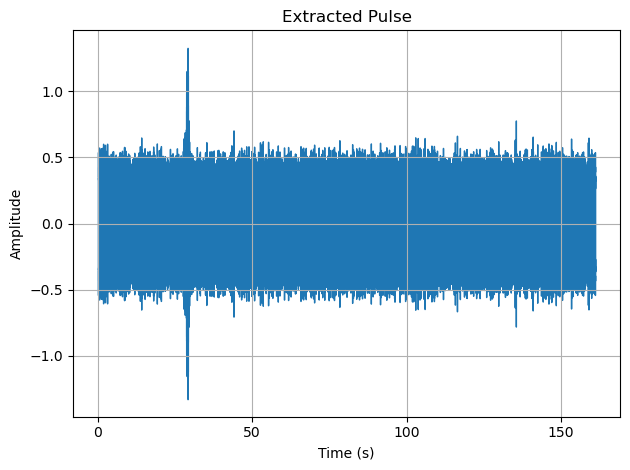

In [75]:
sig = overlap_add(extracted_frames.T, frame_length, hop_length)
lb.display.waveshow(sig, sr=sr,axis='s')
plt.title('Extracted Pulse')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid(True)
plt.show()